In [1]:
import os, sys
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

from os.path import join 
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from IPython.display import display_html

import warnings
warnings.filterwarnings("ignore")

In [2]:
DataPath = r'D:\GitWork\titanic\data'
OutPath  = r'D:\GitWork\titanic\output'

TrainFile  = 'train.csv'
TestFile   = 'test.csv'

In [3]:
# Import train data
f_abspath = join(DataPath, TrainFile)
df_train = pd.read_csv(f_abspath)

display(df_train.head(10))
# display(df_train.info())
# display(df_train.describe())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
# Import test data
f_abspath = join(DataPath, TestFile)
df_test = pd.read_csv(f_abspath)

display(df_test.head(10))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [5]:
# features = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Fare']
# df_data = df_train[features].copy()
# display(df_data.info())

In [6]:
def plotBarStacked(df_plt, ax, title=None, xlabel=None, ylabel=None):
    ax.set_title('{}'.format(title))
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('{}'.format(ylabel))
    df_plt.plot(kind='bar', stacked=True, rot=0, ax=ax)

    offset = 30
    dic_top = {}
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        left, bottom = p.get_xy()
        val = bottom + height
        
        if left not in dic_top: 
            dic_top[left] = 5 if height<5 else height
        else:
            dic_top[left] += height if height > offset else offset
        top = dic_top[left]

        ax.annotate(
            '{}'.format(val),
            xy = (left+width/2, top),
            xytext = (0, 1),
            textcoords = "offset points",
            ha = 'center', 
            va = 'bottom'
        )
    return

def plotBarUnstack(df_plt, ax, title=None, xlabel=None, ylabel=None):
    ax.set_title('{}'.format(title))
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('{}'.format(ylabel))
    df_plt.plot(kind='bar', stacked=False, rot=0, ax=ax)

    for p in ax.patches:
        width  = p.get_width()
        height = p.get_height()
        left, bottom = p.get_xy()
        val = p.get_height()
        ax.annotate(
            '{}'.format(val),
            xy = (left+width/2, height),
            xytext = (0, 1),
            textcoords = "offset points",
            ha = 'center', 
            va = 'bottom'
        )
    return

def cats2dict(le, forward=True):
    return { 
        (x if forward else le.transform([x])[0])
        : (le.transform([x])[0] if forward else x)
        for x in le.classes_
    }


Dict sex: {'female': 0, 'male': 1}


Survived,0,1,Total,S_Rate
Sex,,,,
female,81,233,314,0.742
male,468,109,577,0.189
Total,549,342,891,0.384


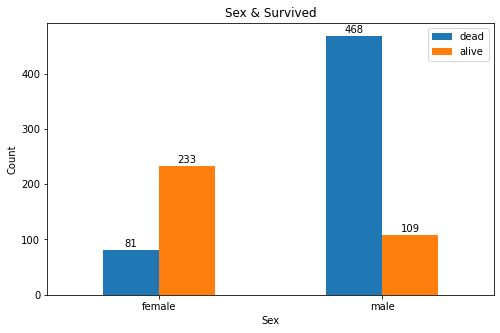

In [7]:
# Process Sex

features = ['Survived', 'Sex']
df_tmp = df_train[features]

le = LabelEncoder()
df_tmp['SexCode'] = le.fit_transform(df_tmp.Sex)
# display(df_sex.head())

dict_sex = cats2dict(le)
print('Dict sex:', dict_sex)
# dict_sex_bw = cats2dict(le, forward=False)
# print('Dict sex bw:', dict_sex_bw)

# Cross table for analysis
ct = pd.crosstab(df_tmp.Sex, df_tmp.Survived, margins=True, margins_name='Total')
ct['S_Rate'] = (ct[1] / ct.Total).round(3)
display(ct)

# Plot SexCode v.s. Survived figure
df_plot = pd.DataFrame({
    'dead' : df_tmp.Sex[df_tmp.Survived==0].value_counts(),
    'alive': df_tmp.Sex[df_tmp.Survived==1].value_counts()
})

fig, ax = plt.subplots(figsize=(8,5))
plotBarUnstack(df_plot, ax, 'Sex & Survived', 'Sex', 'Count')
plt.show()

Survived,0,1,Total,S1_Rate
Pclass,,,,
1,80,136,216,0.630
2,97,87,184,0.473
3,372,119,491,0.242
Total,549,342,891,0.384


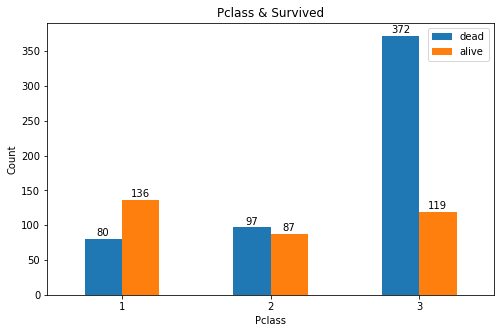

In [8]:
# Process Pclass
features = ['Survived', 'Pclass']
df_tmp = df_train[features]

# Cross table
ct = pd.crosstab(df_tmp.Pclass, df_tmp.Survived, margins=True, margins_name='Total')
ct['S1_Rate'] = (ct[1] / ct.Total).round(3)
display(ct)

df_plot = pd.DataFrame({
    'dead' : df_tmp.Pclass[df_tmp.Survived==0].value_counts(),
    'alive': df_tmp.Pclass[df_tmp.Survived==1].value_counts()
})

fig, ax = plt.subplots(figsize=(8,5))
plotBarUnstack(df_plot, ax, 'Pclass & Survived', 'Pclass', 'Count')
plt.show()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

Bins: [0, 7, 14, 31, 513]


IntervalIndex([[0, 7), [7, 14), [14, 31), [31, 513)],
              closed='left',
              dtype='interval[int64]')

Survived,0,1,Total,S1_Rate
BinCode,,,,
0,26,2,28,0.071
1,299,109,408,0.267
2,130,100,230,0.435
3,94,131,225,0.582
Total,549,342,891,0.384


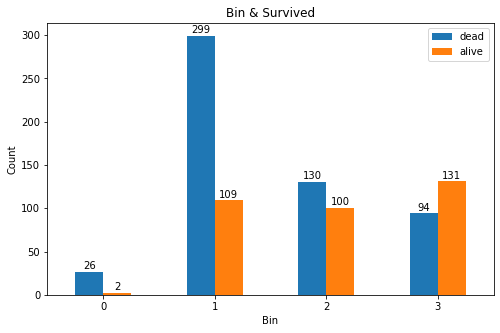

In [9]:
# Process Fare 1
features = ['Survived','Fare']
df_tmp = df_train[features]

desc = df_tmp.Fare.describe()
display(desc)

# define bins according to describe information
start = math.floor(df_tmp.Fare.min())
stop  = math.ceil(df_tmp.Fare.max())
cols_desc = ['25%', '50%', '75%']
bins = [start] + desc[cols_desc].astype(int).tolist() + [stop]
print('Bins:', bins)

cuts = pd.cut(df_tmp.Fare, bins, right=False)
df_tmp['Bin'] = cuts.values
display(cuts.cat.categories)

le = LabelEncoder()
df_tmp['BinCode'] = le.fit_transform(df_tmp.Bin)

# Cross table
ct = pd.crosstab(df_tmp.BinCode, df_tmp.Survived, margins=True, margins_name='Total')
ct['S1_Rate'] = (ct[1] / ct.Total).round(3)
display(ct)

df_plot = pd.DataFrame({
    'dead' : df_tmp.BinCode[df_tmp.Survived==0].value_counts(),
    'alive': df_tmp.BinCode[df_tmp.Survived==1].value_counts()
})

fig, ax = plt.subplots(figsize=(8,5))
plotBarUnstack(df_plot, ax, 'Bin & Survived', 'Bin', 'Count')
plt.show()

bins: [  0  57 114 171 228 285 342 399 456 513]

Intervals:
  [0, 57), [57, 114), [114, 171), [171, 228), [228, 285), [285, 342), [342, 399), [399, 456), [456, 513)

Interval dict:


{Interval(0, 7, closed='left'): 0,
 Interval(7, 14, closed='left'): 1,
 Interval(14, 31, closed='left'): 2,
 Interval(31, 513, closed='left'): 3}

Survived,0,1,Total,S1_Rate
BinCode,,,,
0,509,255,764,0.334
1,30,55,85,0.647
2,4,18,22,0.818
3,3,6,9,0.667
4,3,5,8,0.625
5,0,3,3,1.000
Total,549,342,891,0.384


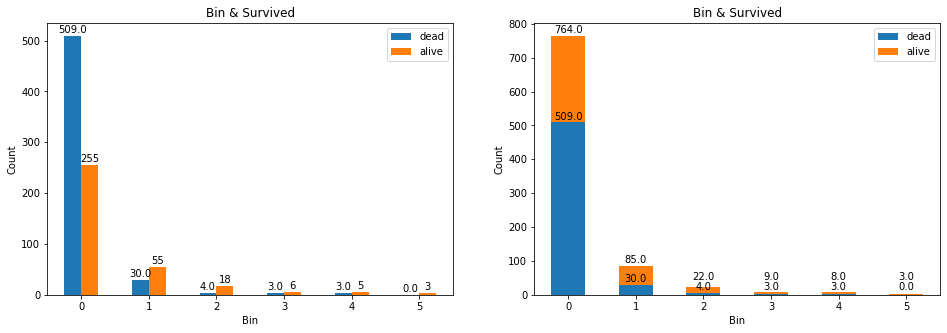

In [10]:
# Process Fare 2
features = ['Survived', 'Fare']
df_tmp = df_train[features]
# display(df1)

steps = 10
start = math.floor(df_tmp.Fare.min())
stop  = math.ceil(df_tmp.Fare.max())
bins  = np.linspace(start, stop, steps, dtype=int)
print('bins:', bins)

cuts = pd.cut(df_tmp.Fare, bins, right=False)
df_tmp['Bin'] = cuts.values
# display(df_tmp)

# len_cuts = len(cuts.values)
# print(len_cuts)

cats = cuts.cat.categories

def printCats(cats, title='', indent=2):
    print(title)
    print(" "*indent, end='')
    isFirst = True
    for i, iv in enumerate(cats):
        fmt_str = '[{}, {})'
        if iv.closed=='right':   fmt_str = '({}, {}]'
        if iv.closed=='both':    fmt_str = '[{}, {}]'
        if iv.closed=='neither': fmt_str = '({}, {})'
        if isFirst: 
            isFirst = False
        else:
            print(', ', end='')
        print(fmt_str.format(iv.left, iv.right), end='')
    print()    
    return
printCats(cats, '\nIntervals:')

# Fare dict
dict_fare = cats2dict(le)
print('\nInterval dict:')
display(dict_fare)

le = LabelEncoder()
df_tmp['BinCode'] = le.fit_transform(df_tmp.Bin)

# Cross table
ct = pd.crosstab(df_tmp.BinCode, df_tmp.Survived, margins=True, margins_name='Total')
ct['S1_Rate'] = (ct[1] / ct.Total).round(3)
display(ct)

df_plot = pd.DataFrame({
    'dead' : df_tmp.BinCode[df_tmp.Survived==0].value_counts(),
    'alive': df_tmp.BinCode[df_tmp.Survived==1].value_counts()
})

fig, axes = plt.subplots(1,2,figsize=(16,5))
plotBarUnstack(df_plot, axes[0], 'Bin & Survived', 'Bin', 'Count')
plotBarStacked(df_plot, axes[1], 'Bin & Survived', 'Bin', 'Count')
plt.show()

In [11]:
# Can log value solve data slope situation?
features = ['Survived', 'Pclass', 'Fare']
df_tmp = df_train[features]

df_tmp['Log_Fare'] = (df_tmp.Fare+1).map(lambda x : np.log10(x) if x > 0 else 0)
display(df_tmp.Log_Fare.describe())

indexes = ['Pclass']
values  = ['Fare']
pt = df_tmp.pivot_table(values=values, index=indexes, columns=['Survived'], aggfunc='mean').round(3)
# pt = pd.pivot_table(df_tmp, index=indexes, columns=['Survived'], aggfunc='median').round(3)
display(pt)

count    891.000000
mean       1.286487
std        0.420852
min        0.000000
25%        0.949897
50%        1.189047
75%        1.505150
max        2.710396
Name: Log_Fare, dtype: float64

Fare        
Survived       0       1
Pclass                  
1         64.684  95.608
2         19.412  22.056
3         13.669  13.695

,Survived,Pclass,Fare,Bin4,Bin5,Bin6,Bin4_Code,Bin5_Code,Bin6_Code
0,0,3,7.2500,"(-0.001, 7.91]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0
1,1,1,71.2833,"(31.0, 512.329]","(39.688, 512.329]","(52.369, 512.329]",3,4,5
2,1,3,7.9250,"(7.91, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1
3,1,1,53.1000,"(31.0, 512.329]","(39.688, 512.329]","(52.369, 512.329]",3,4,5
4,0,3,8.0500,"(7.91, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1


Pclass 
 1 
 2 
 3 
 Total 
 
 
 Bin4_Code 
 Survived 
 
 
 
 
 
 
 
 
 0 
 0 
 6 
 6 
 167 
 179 
 
 
 1 
 0 
 0 
 44 
 44 
 
 
 1 
 0 
 0 
 53 
 103 
 156 
 
 
 1 
 0 
 33 
 35 
 68 
 
 
 2 
 0 
 24 
 28 
 69 
 121 
 
 
 1 
 27 
 42 
 32 
 101 
 
 
 3 
 0 
 50 
 10 
 33 
 93 
 
 
 1 
 109 
 12 
 8 
 129 
 
 
 Total 
 
 216 
 184 
 491 
 891 
 
 
 
 
 
 
 Pclass 
 1 
 2 
 3 
 Total 
 
 
 Bin5_Code 
 Survived 
 
 
 
 
 
 
 
 
 0 
 0 
 6 
 6 
 128 
 140 
 
 
 1 
 0 
 0 
 39 
 39 
 
 
 1 
 0 
 0 
 15 
 132 
 147 
 
 
 1 
 0 
 9 
 28 
 37 
 
 
 2 
 0 
 0 
 45 
 54 
 99 
 
 
 1 
 0 
 35 
 38 
 73 
 
 
 3 
 0 
 32 
 25 
 43 
 100 
 
 
 1 
 32 
 39 
 9 
 80 
 
 
 4 
 0 
 42 
 6 
 15 
 63 
 
 
 1 
 104 
 4 
 5 
 113 
 
 
 Total 
 
 216 
 184 
 491 
 891 
 
 
 
 
 
 
 Pclass 
 1 
 2 
 3 
 Total 
 
 
 Bin6_Code 
 Survived 
 
 
 
 
 
 
 
 
 0 
 0 
 6 
 6 
 112 
 124 
 
 
 1 
 0 
 0 
 32 
 32 
 
 
 1 
 0 
 0 
 0 
 123 
 123 
 
 
 1 
 0 
 0 
 29 
 29 
 
 
 2 
 0 
 0 
 53 
 35 
 88 
 
 
 1 
 0 
 33 
 18 
 51 
 
 
 3 
 0 
 4 
 22 
 58 
 84 
 
 
 1 
 2 
 31 
 32 
 65 
 
 
 4 
 0 
 39 
 11 
 35 
 85 
 
 
 1 
 37 
 21 
 3 
 61 
 
 
 5 
 0 
 31 
 5 
 9 
 45 
 
 
 1 
 97 
 2 
 5 
 104 
 
 
 Total 
 
 216 
 184 
 491 
 891

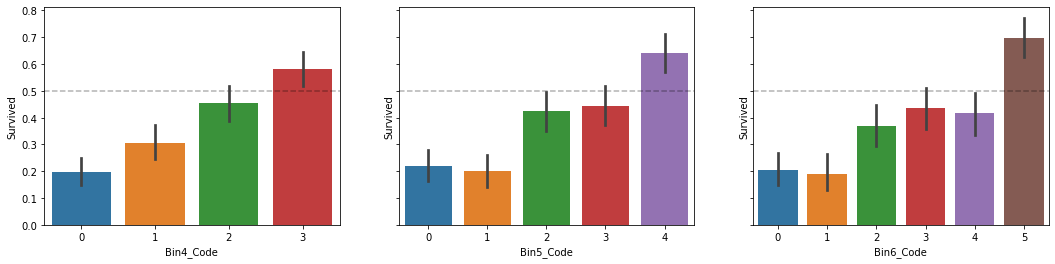

In [12]:
# Process Fare 3: 
# Slice fare by accumulation percentage value counts

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin:20px"'), raw=True)
    
features = ['Survived', 'Pclass', 'Fare']
df_tmp = df_train[features]
    
df_tmp['Bin4'] = pd.qcut(df_tmp['Fare'], 4)
df_tmp['Bin5'] = pd.qcut(df_tmp['Fare'], 5)
df_tmp['Bin6'] = pd.qcut(df_tmp['Fare'], 6)
# display(df_tmp.head())

le = LabelEncoder()
df_tmp['Bin4_Code'] = le.fit_transform(df_tmp['Bin4'])
df_tmp['Bin5_Code'] = le.fit_transform(df_tmp['Bin5'])
df_tmp['Bin6_Code'] = le.fit_transform(df_tmp['Bin6'])
display(df_tmp.head())

# df_4 = pd.crosstab(df_tmp.Bin4_Code, df_tmp.Pclass)
# df_5 = pd.crosstab(df_tmp.Bin4_Code, df_tmp.Pclass)
# df_6 = pd.crosstab(df_tmp.Bin4_Code, df_tmp.Pclass)

kwargs = { 'margins': True, 'margins_name': 'Total' }
df_4 = pd.crosstab([df_tmp.Bin4_Code, df_tmp.Survived], df_tmp.Pclass, **kwargs)
df_5 = pd.crosstab([df_tmp.Bin5_Code, df_tmp.Survived], df_tmp.Pclass, **kwargs)
df_6 = pd.crosstab([df_tmp.Bin6_Code, df_tmp.Survived], df_tmp.Pclass, **kwargs)

# df_4 = pd.crosstab([df_tmp.Bin4_Code, df_tmp.Survived], df_tmp['Pclass'], **kwargs)
# df_5 = pd.crosstab([df_tmp.Bin5_Code, df_tmp.Survived], df_tmp['Pclass'], **kwargs)
# df_6 = pd.crosstab([df_tmp.Bin6_Code, df_tmp.Survived], df_tmp['Pclass'], **kwargs)

display_side_by_side(df_4, df_5, df_6)

fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(18)

for ax in axes:
    ax.axhline(0.5, linestyle='dashed', c='black', alpha=0.3)
g0 = sns.barplot(x='Bin4_Code', y='Survived', data=df_tmp, ax=axes[0])
g1 = sns.barplot(x='Bin5_Code', y='Survived', data=df_tmp, ax=axes[1])
g2 = sns.barplot(x='Bin6_Code', y='Survived', data=df_tmp, ax=axes[2])

plt.show()

In [13]:
from sklearn.feature_selection import RFECV

features = ['Survived', 'Sex', 'Pclass', 'Fare']
df1 = df_train[features]
# display(df1.head())

def classes2dict(cls):
    return {
        le.transform([x])[0]: x for x in le.classes_
    }

# Transform sex label to number
le = LabelEncoder()
df1['SexCode'] = le.fit_transform(df1.Sex)

# Split fare as equal intervals of 4, 5 or 6 
df1['FareBin_4'] = pd.qcut(df1.Fare, 4)
df1['FareBin_5'] = pd.qcut(df1.Fare, 5)
df1['FareBin_6'] = pd.qcut(df1.Fare, 6)

df1['FareBinCode_4'] = le.fit_transform(df1.FareBin_4)
dict_bin4 = classes2dict(le.classes_)
print('\nBin4 dict:'); display(dict_bin4)

df1['FareBinCode_5'] = le.fit_transform(df1.FareBin_5)
dict_bin5 = classes2dict(le.classes_)
print('Bin5 dict:'); display(dict_bin5)

df1['FareBinCode_6'] = le.fit_transform(df1.FareBin_6)
dict_bin6 = classes2dict(le.classes_)
print('Bin6 dict:'); display(dict_bin6)

display(df1.head())

# Training set and labels
compare = ['SexCode', 'Pclass', 'FareBinCode_4', 'FareBinCode_5', 'FareBinCode_6']
X = df1[compare]
Y = df1['Survived']
display(X.columns)

selector = RFECV(RandomForestClassifier(n_estimators=250, min_samples_split=20), cv=10, n_jobs=-1)
selector.fit(X, Y)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100)


Bin4 dict:


{0: Interval(-0.001, 7.91, closed='right'),
 1: Interval(7.91, 14.454, closed='right'),
 2: Interval(14.454, 31.0, closed='right'),
 3: Interval(31.0, 512.329, closed='right')}

Bin5 dict:


{0: Interval(-0.001, 7.854, closed='right'),
 1: Interval(7.854, 10.5, closed='right'),
 2: Interval(10.5, 21.679, closed='right'),
 3: Interval(21.679, 39.688, closed='right'),
 4: Interval(39.688, 512.329, closed='right')}

Bin6 dict:


{0: Interval(-0.001, 7.775, closed='right'),
 1: Interval(7.775, 8.662, closed='right'),
 2: Interval(8.662, 14.454, closed='right'),
 3: Interval(14.454, 26.0, closed='right'),
 4: Interval(26.0, 52.369, closed='right'),
 5: Interval(52.369, 512.329, closed='right')}

,Survived,Sex,Pclass,Fare,SexCode,FareBin_4,FareBin_5,FareBin_6,FareBinCode_4,FareBinCode_5,FareBinCode_6
0,0,male,3,7.2500,1,"(-0.001, 7.91]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0
1,1,female,1,71.2833,0,"(31.0, 512.329]","(39.688, 512.329]","(52.369, 512.329]",3,4,5
2,1,female,3,7.9250,0,"(7.91, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1
3,1,female,1,53.1000,0,"(31.0, 512.329]","(39.688, 512.329]","(52.369, 512.329]",3,4,5
4,0,male,3,8.0500,1,"(7.91, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1


Index(['SexCode', 'Pclass', 'FareBinCode_4', 'FareBinCode_5', 'FareBinCode_6'], dtype='object')

[ True  True  True  True  True]
[1 1 1 1 1]
[78.67290886 77.7815231  79.24219725 79.46816479 80.58801498]


In [14]:
# Consider random_state and Cross-Validation
df_score = pd.DataFrame(columns=['B4', 'B5', 'B6'])

n_splits = 10
for i in range(n_splits):
    diff_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=i)
    selector = RFECV(
        RandomForestClassifier(n_estimators=250, min_samples_split=20), 
        cv = diff_cv, 
        n_jobs = -1
    )
    selector.fit(X, Y)
    scores = selector.grid_scores_[2:5]
    print('{}: {}'.format(i, scores))
    df_score.loc[len(df_score), :] = scores

0: [0.79012484 0.78902622 0.79350811]
1: [0.79237203 0.79350811 0.80808989]
2: [0.79571785 0.79458177 0.80470662]
3: [0.79456929 0.80579276 0.80581773]
4: [0.7890387  0.79689139 0.79689139]
5: [0.80139825 0.80699126 0.809201  ]
6: [0.7935206  0.80583021 0.80695381]
7: [0.79574282 0.80579276 0.80581773]
8: [0.78910112 0.79921348 0.80146067]
9: [0.80019975 0.80583021 0.8080774 ]


<AxesSubplot:>

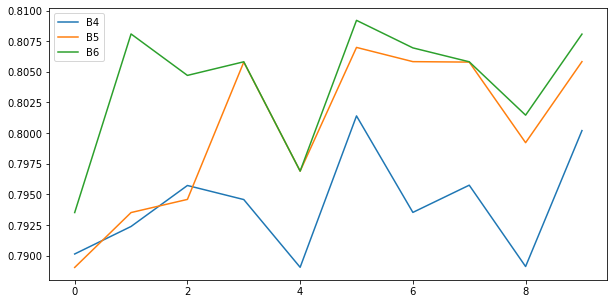

In [15]:
# display(df_score)
df_score.plot(figsize=(10,5))

In [25]:
# Training
features = ['Survived', 'Sex','Pclass', 'Fare']
df_data = df_train[features]

# Transform sex label to number
le = LabelEncoder()
df_data.insert(2, 'SexCode', le.fit_transform(df_data.Sex))
# display(df_data.head())

dict_sex = classes2dict(le.classes_)
print('Sex dict:', dict_sex)

# Process Fare
df_data['FareBin_4'] = pd.qcut(df_data.Fare, 4)
df_data['FareBin_5'] = pd.qcut(df_data.Fare, 5)
df_data['FareBin_6'] = pd.qcut(df_data.Fare, 6)

df_data['FareBinCode_4'] = le.fit_transform(df_data.FareBin_4)
df_data['FareBinCode_5'] = le.fit_transform(df_data.FareBin_5)
df_data['FareBinCode_6'] = le.fit_transform(df_data.FareBin_6)
display(df_data.head())

features4 = ['SexCode', 'Pclass', 'FareBinCode_4']
features5 = ['SexCode', 'Pclass', 'FareBinCode_5']
features6 = ['SexCode', 'Pclass', 'FareBinCode_6']

inp4 = df_data.filter(features4, axis=1)
inp5 = df_data.filter(features5, axis=1)
inp6 = df_data.filter(features6, axis=1)
lbls = df_data.Survived

model_b4 = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
model_b4.fit(inp4, lbls)
print('oob score :%f' %(model_b4.oob_score_))

model_b5 = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
model_b5.fit(inp5, lbls)
print('oob score :%f' %(model_b5.oob_score_))

model_b6 = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
model_b6.fit(inp6, lbls)
print('oob score :%f' %(model_b6.oob_score_))

dict_scores = {
    4: model_b4.oob_score_, 
    5: model_b5.oob_score_,
    6: model_b6.oob_score_
}

import operator
best_model_num = max(dict_scores, key=dict_scores.get)
print('\nBest model:', best_model_num)

Sex dict: {0: 'female', 1: 'male'}


,Survived,Sex,SexCode,Pclass,Fare,FareBin_4,FareBin_5,FareBin_6,FareBinCode_4,FareBinCode_5,FareBinCode_6
0,0,male,1,3,7.2500,"(-0.001, 7.91]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0
1,1,female,0,1,71.2833,"(31.0, 512.329]","(39.688, 512.329]","(52.369, 512.329]",3,4,5
2,1,female,0,3,7.9250,"(7.91, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1
3,1,female,0,1,53.1000,"(31.0, 512.329]","(39.688, 512.329]","(52.369, 512.329]",3,4,5
4,0,male,1,3,8.0500,"(7.91, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1


oob score :0.796857
oob score :0.810325
oob score :0.801347

Best model: 5


In [26]:
# Prediction
le = LabelEncoder()

df_data = pd.DataFrame({
    'PassengerId': df_test.PassengerId,
    'Pclass' : df_test.Pclass,
    'Fare'   : df_test.Fare,
    'SexCode': le.fit_transform(df_test.Sex)
})
display(df_data.info())

# Fill nan values of Fare column
df_data.Fare.fillna(0, inplace=True)
# display(df_data.info())

# Process Fare
df_data['FareBin'] = pd.qcut(df_data.Fare, best_model_num)
df_data['FareBinCode'] = le.fit_transform(df_data.FareBin)
# display(df_pred.head())

features5 = ['SexCode', 'Pclass', 'FareBinCode']
inp5 = df_data.filter(features5, axis=1)

df_data['Survived'] = model_b5.predict(inp5)
display(df_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Fare         417 non-null    float64
 3   SexCode      418 non-null    int32  
dtypes: float64(1), int32(1), int64(2)
memory usage: 11.6 KB


None

,PassengerId,Pclass,Fare,SexCode,FareBin,FareBinCode,Survived
0,892,3,7.8292,1,"(7.796, 10.667]",1,0
1,893,3,7.0000,0,"(-0.001, 7.796]",0,1
2,894,2,9.6875,1,"(7.796, 10.667]",1,0
3,895,3,8.6625,1,"(7.796, 10.667]",1,0
4,896,3,12.2875,0,"(10.667, 21.196]",2,1
...,...,...,...,...,...,...,...
413,1305,3,8.0500,1,"(7.796, 10.667]",1,0
414,1306,1,108.9000,0,"(46.34, 512.329]",4,1
415,1307,3,7.2500,1,"(-0.001, 7.796]",0,0
416,1308,3,8.0500,1,"(7.796, 10.667]",1,0


In [27]:
# Save predict result to xlsx
f_abspath = join(OutPath, 'Submission_Fare5.csv')

features = ['PassengerId', 'Survived']
df_subm = df_data[features]
df_subm.to_csv(f_abspath, index=False)